In [ ]:
#!pip install
!pip install geopy --quiet
!pip install scikit-learn --quiet
!pip install statsmodels --quiet
!pip install scipy --quiet

# imports
from geopy.distance import geodesic
import math
from math import exp
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import kruskal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
import string
import warnings


pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Carregando o DataFrame
df_original = pd.read_csv('teste_indicium_precificacao.csv')

# Vizualizando o Dataframe
df_original.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [ ]:
# Checando informações
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Nessa visão inicial dos dados vemos que:

- temos 48894 linhas com 16 variáveis (duas delas representam ids (id, host_id)).
- temos valores nulos nas variáveis ultima_review,reviews por mês, nome e host_name.
- temos 3 variáveis do tipo float, 7 do tipo inteiro e 6 variáveis categóricas ou de texto.
- A variável última review representa uma data e está como tipo object.
- Também chama atenção que a variável price é tratado como int e não como float.

### Vamos alterar os tipos da variável ultima_review para date

In [ ]:
# Criando uma copia do dataset original
df = df_original.copy()

# Alterando o tipo da coluna ultima_review para datetime
df['ultima_review'] = pd.to_datetime(df['ultima_review'])

# Verificando tipos das variáveis do novo dataframe
df.ultima_review.dtypes

dtype('<M8[ns]')

### Observando um resumo estatístico da variável alvo

In [ ]:
df_original.price.describe()

,price
count,48894.000000
mean,152.720763
std,240.156625
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


Temos valores iguais a 0 no preço, vamos verirficar

In [ ]:
# Verificando quantos dados do df tem preco = 0
df[df.price == 0].shape[0]

11

Apenas 11 valores com preço = 0, parece ser um erro. Como são poucos dados podemos remove-los posteriormente.

In [ ]:
# Função para remover valores do df que sao 0
def remover_zeros(df, coluna):
    df = df[df[coluna] != 0]
    return df

In [ ]:
# Aplicando a funcao para a coluna price
df = remover_zeros(df, 'price')

# Verificando se os valores foram removidos
df[df.price == 0].shape[0]

0

### Verificando o resumo estastístico da variável alvo novamente

In [ ]:
# Resumo estatistico da variavel alvo
df.price.describe()

,price
count,48883.000000
mean,152.755130
std,240.172716
min,10.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


Agora o valor de alugel mais baixo é 10, temos uma grande amplitude nos dados, com o valor max chegando a 10000.000000, mas com o valor do terceiro quartil sendo de apenas 175.000000. Também temos um alto desvio padrão e a média consideravelmente diferente da mediana. Essas característicam indicam uma distribuição com outliers e uma longa cauda a direita.

### Vamos verificar a distribuição da variável alvo

<Axes: xlabel='price', ylabel='Count'>

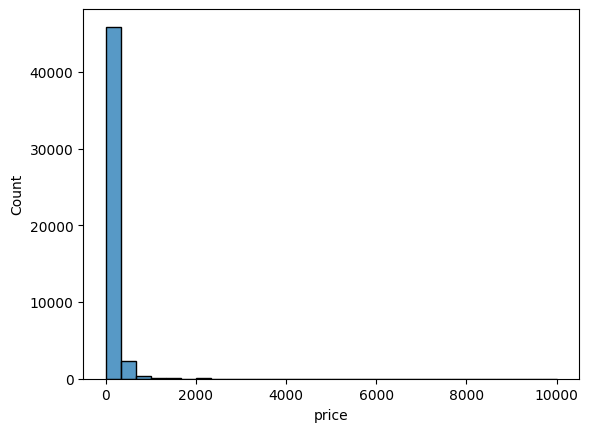

In [ ]:
# Verificando distribuição da variável alvo atraves de um histograma
sns.histplot(data=df, x= df_original['price'], bins = 30)

<Axes: ylabel='price'>

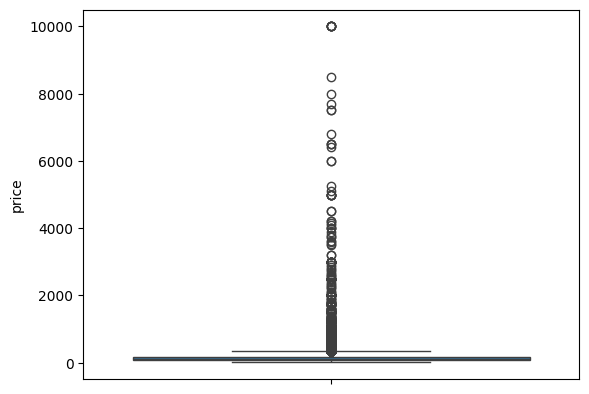

In [ ]:
# Verificando distribuição da variável alvo atraves de um boxplot
sns.boxplot(data=df, y = 'price')

Realmente as suspeitas eram verdadeiras, existem valores muito discrepantes e uma calda bem longa a direita.

In [ ]:
# Verificando o percentil 0.9
df.price.quantile(0.90)

269.0

apenas 10% dos valores estão entre 269 e 10000

In [ ]:
# Verificando o percentil 0.99
df.price.quantile(0.99)

799.0

apenas 1% dos valores estão entre 799 e 10000

### Vamos verificar a distribuicao das variáveis independentes


array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimo_noites'}>],
       [<Axes: title={'center': 'numero_de_reviews'}>,
        <Axes: title={'center': 'reviews_por_mes'}>,
        <Axes: title={'center': 'calculado_host_listings_count'}>],
       [<Axes: title={'center': 'disponibilidade_365'}>, <Axes: >,
        <Axes: >]], dtype=object)

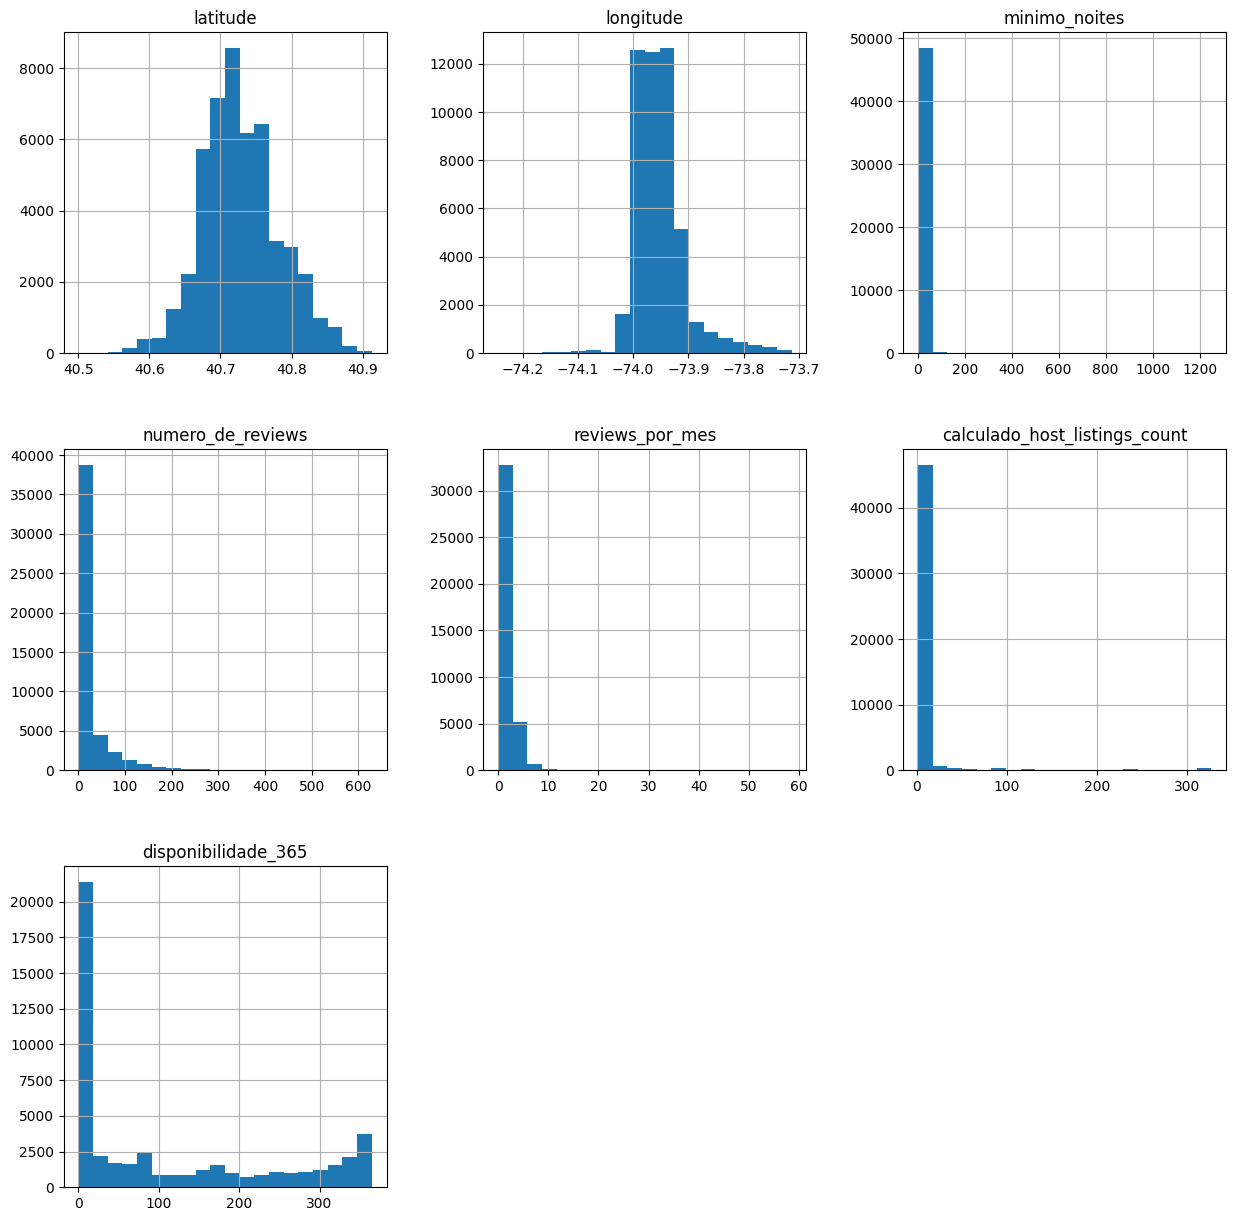

In [ ]:
# Fazendo a verificacao removendo variaveis de id, variavel price que ja foi vista e ultima review que e do tipo data
df.drop(['id', 'host_id','price','ultima_review'], axis = 1).hist(figsize=(15,15), bins=20)

Todas as demais variáveis tem um cauda longa a direita assim como price, menos as variáveis latitude e longitude que tem uma distribuição que se aproxima bem mais de uma normal.

In [ ]:
df.drop(['id', 'host_id','price','ultima_review'], axis = 1).describe()

,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48883.000000,48883.000000,48883.000000,48883.000000,38832.000000,48883.000000,48883.000000
mean,40.728954,-73.952175,7.030010,23.272283,1.373158,7.144652,112.774339
std,0.054531,0.046159,20.512416,44.551739,1.680402,32.956522,131.623674
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983080,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723080,-73.955680,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763120,-73.936290,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000


### Vamos verificar a relacao das variaveis contínuas com a variavel price

In [ ]:
# Definindo as variaveis continuas independentes
variaveis_continuas = df.select_dtypes(include=['int64', 'float64']).drop(columns=['id','host_id'])
variaveis_continuas_lista = variaveis_continuas.drop(columns=['price']).columns.tolist()

print(variaveis_continuas_lista)
print(type(variaveis_continuas_lista))

['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
<class 'list'>


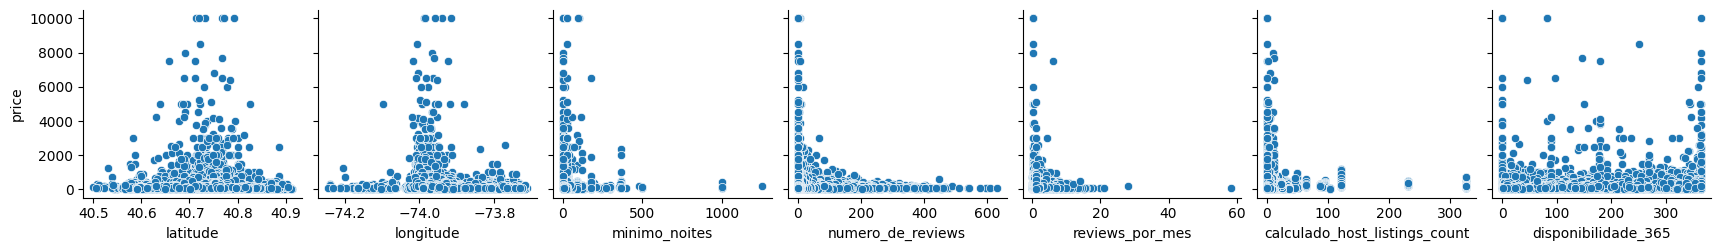

In [ ]:
# Plotando scatter plots das variaveis em relacao a variavel alvo price
sns.pairplot(data=variaveis_continuas, y_vars='price', x_vars=variaveis_continuas_lista, kind = 'scatter')

- Os maiores preços para latitude e longitude correspondem aos valores mais centrais.
- As variáveis numero de reviews e reviews por mês tendem a diminuir conforme o preço aumenta.
- Já as variáveis minimo_noites e disponibiidade_365 aumentam ligeiramente.
- A variável disponibilidade_365 parece ser bem distribuída entre os diferentes preços.
- As variáveis não se relacionam de forma linear com a variável alvo.
- As caudas muito longas a direita com valores muito discrepantes alteram as distribuições e os gráficos.

#### Hipoteses:

1. Mais reviews para valores com preços mais baixos está relacionado a uma popularidade maior para preços mais acessíveis.
2. Já uma disponibilidade ligeiramente maior para preços mais caros pode estar relacionado também a maior popularidade em preços menores, apesar de a variável ser bem distribuîda.


### Vamos verificar os coeficientes de correlação das variáveis com a variável alvo

In [ ]:
variaveis_continuas.corr().price.sort_values(ascending=False)

,price
price,1.000000
disponibilidade_365,0.081851
calculado_host_listings_count,0.057462
minimo_noites,0.042805
latitude,0.033899
reviews_por_mes,-0.030575
numero_de_reviews,-0.047926
longitude,-0.149955


### Gerando uma matriz de correlação

In [ ]:
# Função para filtrar e visualizar correlação
def filtrar_e_visualizar_correlacao(df, threshold, drop_column = None):

    # Calcula a matriz de correlação
    corr = df.corr()

    # Aplica os filtros de limiar, excluindo a correlação perfeita
    filtro = (abs(corr) >= threshold) & (corr != 1.0)
    df_filtrado = corr.where(filtro).dropna(how = 'all').dropna(axis = 1, how = 'all')

    # Remove a coluna e linha especificada, se fornecido
    if drop_column:
        df_filtrado = df_filtrado.drop(index = drop_column,
                                       errors = 'ignore').drop(columns = drop_column,
                                                               errors = 'ignore')

    # Visualiza o resultado com um heatmap somente com as variáveis que satisfazem o critério de filtro
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_filtrado, annot = True, cmap = 'coolwarm', center = 0, mask = np.triu(df_filtrado))
    plt.show()

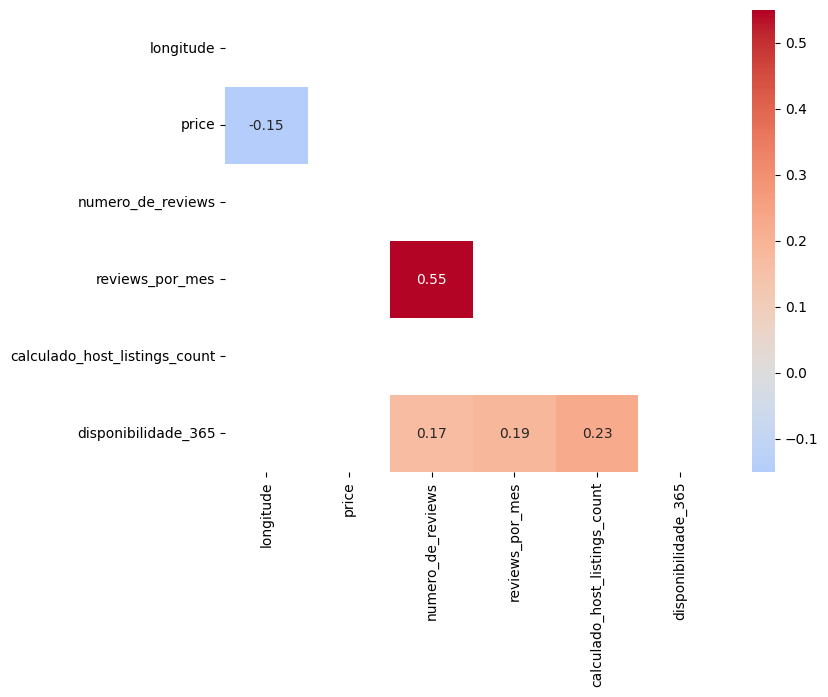

In [ ]:
# Gerando a matriz de correlacao entre as variaveis filtrando apenas as que tem correlacao mais que 0.15 em valor absoluto
filtrar_e_visualizar_correlacao(df=df_original.select_dtypes(include=['int64', 'float64']), threshold=0.15, drop_column= ['id', 'host_id'])

Os coeficientes de correlação entre as variáveis são bem baixos, as únicas variáveis com um valor de coeficiente mais relevante são reviews_por_mes e numero_de_reviews, o que parece óbvio.
A única variável que possui correlácao de 0.15 absoluto ou maior com a variável alvo é a longitude.

### Transformação das variáveis

No contexto observado vamos tentar remover os valores discrepantes nas variáveis que podem alterar as distribuições.

Também aplicaremos transformações de logpara suavizar as caudas a direita.

### Vamos separar 10% dos dados para teste posterior do modelo a ser aplicado

In [ ]:
# Criando um dataset de treino com 90% dos dados do dataset original e um dataset de testes com 10% dos dados do dataset original retirados aleatoriamente
df_treino, df_teste = train_test_split(df, test_size=0.1, random_state=42)

# Resetando os índices
df_treino = df_treino.reset_index(drop=True)
df_teste = df_teste.reset_index(drop=True)

print("Tamanho do dataset de treino:", df_treino.shape)
print("Tamanho do dataset de teste:", df_teste.shape)

Tamanho do dataset de treino: (43994, 16)
Tamanho do dataset de teste: (4889, 16)


### Antes de aplicar as transformaçoes lidaremos com os valores ausentes

As variáveis reviews_por_mes e numero_de_reviews possuem valores ausentes, vamos verificar.

In [ ]:
df_treino.isnull().sum().sort_values(ascending=False)

,0
ultima_review,9007
reviews_por_mes,9007
host_name,21
nome,14
id,0
host_id,0
bairro_group,0
bairro,0
latitude,0
longitude,0


Essas variáveis são relacionadas e tem a mesma quantidade de valores nulos.

#### Hipótese:
Os valores nulos ocorrem em anuncios que nao tiveram review?

### Temos uma variavel chamada numero_de_reviews, vamos verificar se o numero de reviews_por_mes nulas quando o numero_de_reviews = 0, é o mesmo de todo o df, isso prova a hipótese levantada.

In [ ]:
# Filtrando o dataframe por numero de rewies = 0
df_treino[df_treino.numero_de_reviews == 0].reviews_por_mes.isnull().sum() == df_treino['reviews_por_mes'].isnull().sum()

True

Exatamente o mesmo número! Isso prova a hipotese de que os valores nulos em reviews_por_mes são oriundos de anúncios com nenhuma review.

### Decisão:

Assumir que os valores nulos em reviews_por_mes e ultima_review são provenientes de anúncios que não receberam review.

Vamos imputar os valores nulos com 0.




In [ ]:
# Funcao para imputar valores ausentes numa coluna com 0
def imputar_zeros(df, coluna):
    df[coluna] = df[coluna].fillna(0)
    return df

In [ ]:
# imputando zeros na coluna reviews_por_mes
df_treino = imputar_zeros(df_treino, 'reviews_por_mes')
df_teste = imputar_zeros(df_teste, 'reviews_por_mes')

# Verificando se ainda tem valores nulos
df_treino.reviews_por_mes.isnull().values.any()

False

Valores nulos na coluna limpos!

### Agora sim vamos remover os valores extremos

In [ ]:
def remover_valores_extremos(X, colunas, quantile=0.95):
    X = X.copy()
    for col in colunas:
        if col in X.columns:
            limite = X[col].quantile(quantile)
            X[col] = np.where(X[col] > limite, limite, X[col])
    return X

In [ ]:
# Aplicando a funcao para remover os dados 1% maiores
df_treino_continuas_valores_extremos = remover_valores_extremos(df_treino,['price', 'minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count'], quantile=0.99)

# Verificando
df_treino_continuas_valores_extremos[['price', 'minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count']].describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count
count,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000
mean,143.917375,6.111083,22.558803,1.070060,6.513570
std,121.890634,9.224399,40.272586,1.476731,27.161105
min,10.000000,1.000000,0.000000,0.000000,1.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000
75%,175.000000,5.000000,24.000000,1.590000,2.000000
max,799.000000,45.000000,213.000000,6.800000,232.000000


array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimo_noites'}>],
       [<Axes: title={'center': 'numero_de_reviews'}>,
        <Axes: title={'center': 'reviews_por_mes'}>,
        <Axes: title={'center': 'calculado_host_listings_count'}>],
       [<Axes: title={'center': 'disponibilidade_365'}>, <Axes: >,
        <Axes: >]], dtype=object)

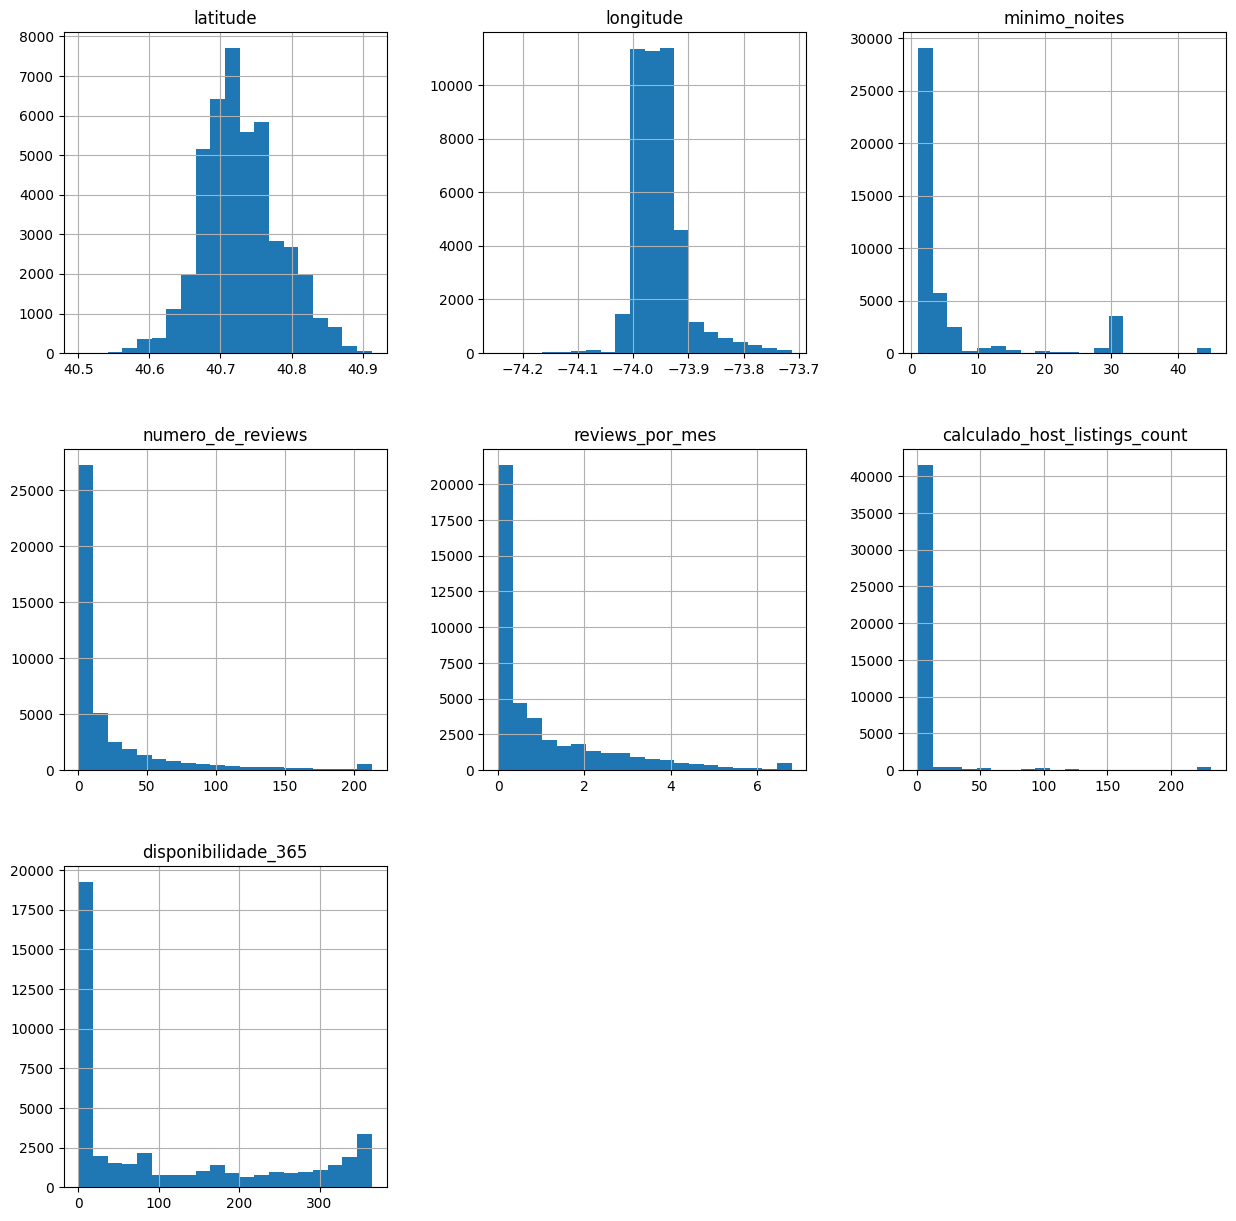

In [ ]:
df_treino_continuas_valores_extremos.drop(['id', 'host_id','price','ultima_review'], axis = 1).hist(figsize=(15,15), bins=20)

As distribuições ficaram um pouco mais suaves mas ainda bem assimétricas.

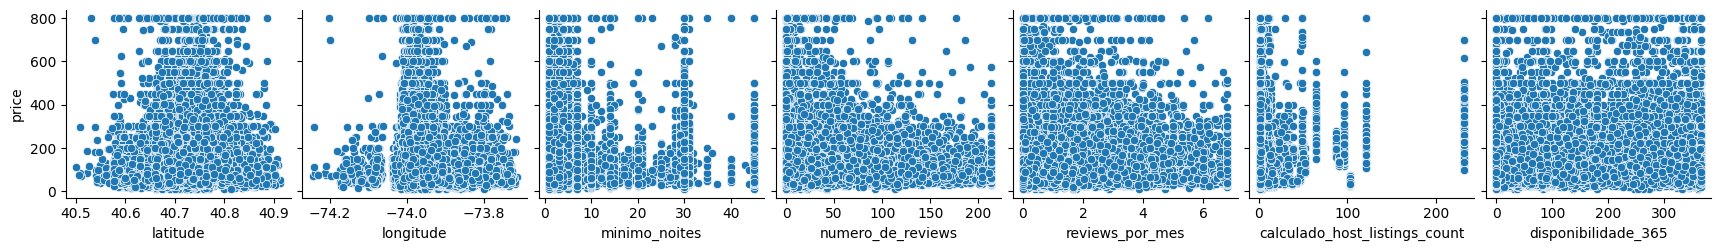

In [ ]:
# Plotando scatter plots das variaveis em relacao a variavel alvo price
sns.pairplot(data=df_treino_continuas_valores_extremos, y_vars='price', x_vars=variaveis_continuas_lista, kind = 'scatter')

In [ ]:
df_treino_continuas_valores_extremos.select_dtypes(include=['int64', 'float64']).drop(columns=['id','host_id']).corr().price.abs().sort_values(ascending=False)

,price
price,1.000000
longitude,0.259602
calculado_host_listings_count,0.126713
disponibilidade_365,0.120631
reviews_por_mes,0.066601
numero_de_reviews,0.065877
latitude,0.061325
minimo_noites,0.048534


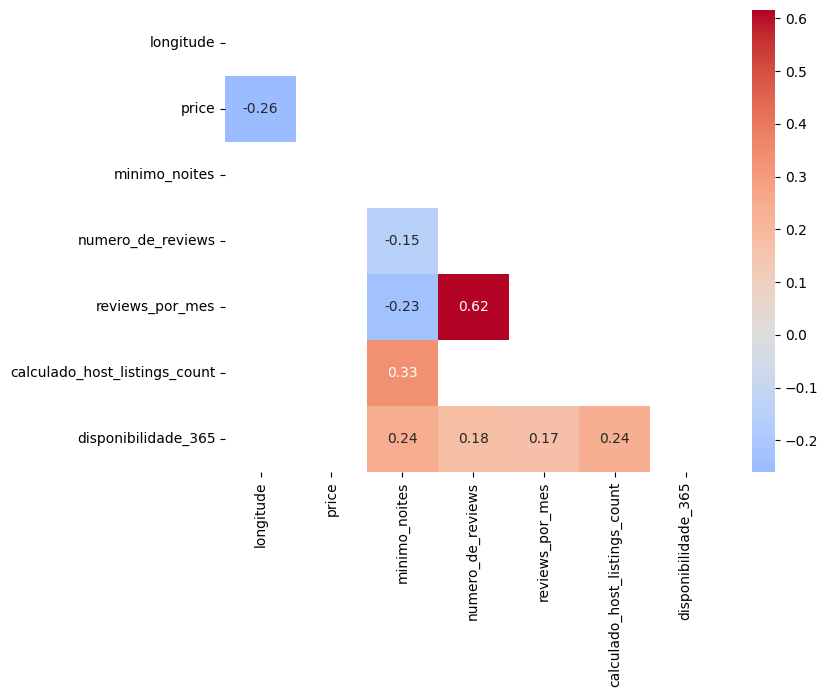

In [ ]:
# Gerando a matriz de correlacao entre as variaveis filtrando apenas as que tem correlacao mais que 0.15 em valor absoluto
filtrar_e_visualizar_correlacao(df=df_treino_continuas_valores_extremos.select_dtypes(include=['int64', 'float64']), threshold=0.15, drop_column= ['id', 'host_id'])

As distribuições se tornaram um pouco mais suaves e os valores de correlação melhoraram um pouco, mas ainda são muito baixas.

In [ ]:
def aplicar_log(X, colunas):
    X = X.copy()
    for col in colunas:
        if col in X.columns:  # Garante que a coluna está no DataFrame
            X[col] = np.log1p(X[col])  # Aplica log1p (log(x + 1)) para evitar log(0)
    return X

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'minimo_noites'}>,
        <Axes: title={'center': 'numero_de_reviews'}>,
        <Axes: title={'center': 'reviews_por_mes'}>],
       [<Axes: title={'center': 'calculado_host_listings_count'}>,
        <Axes: title={'center': 'disponibilidade_365'}>, <Axes: >]],
      dtype=object)

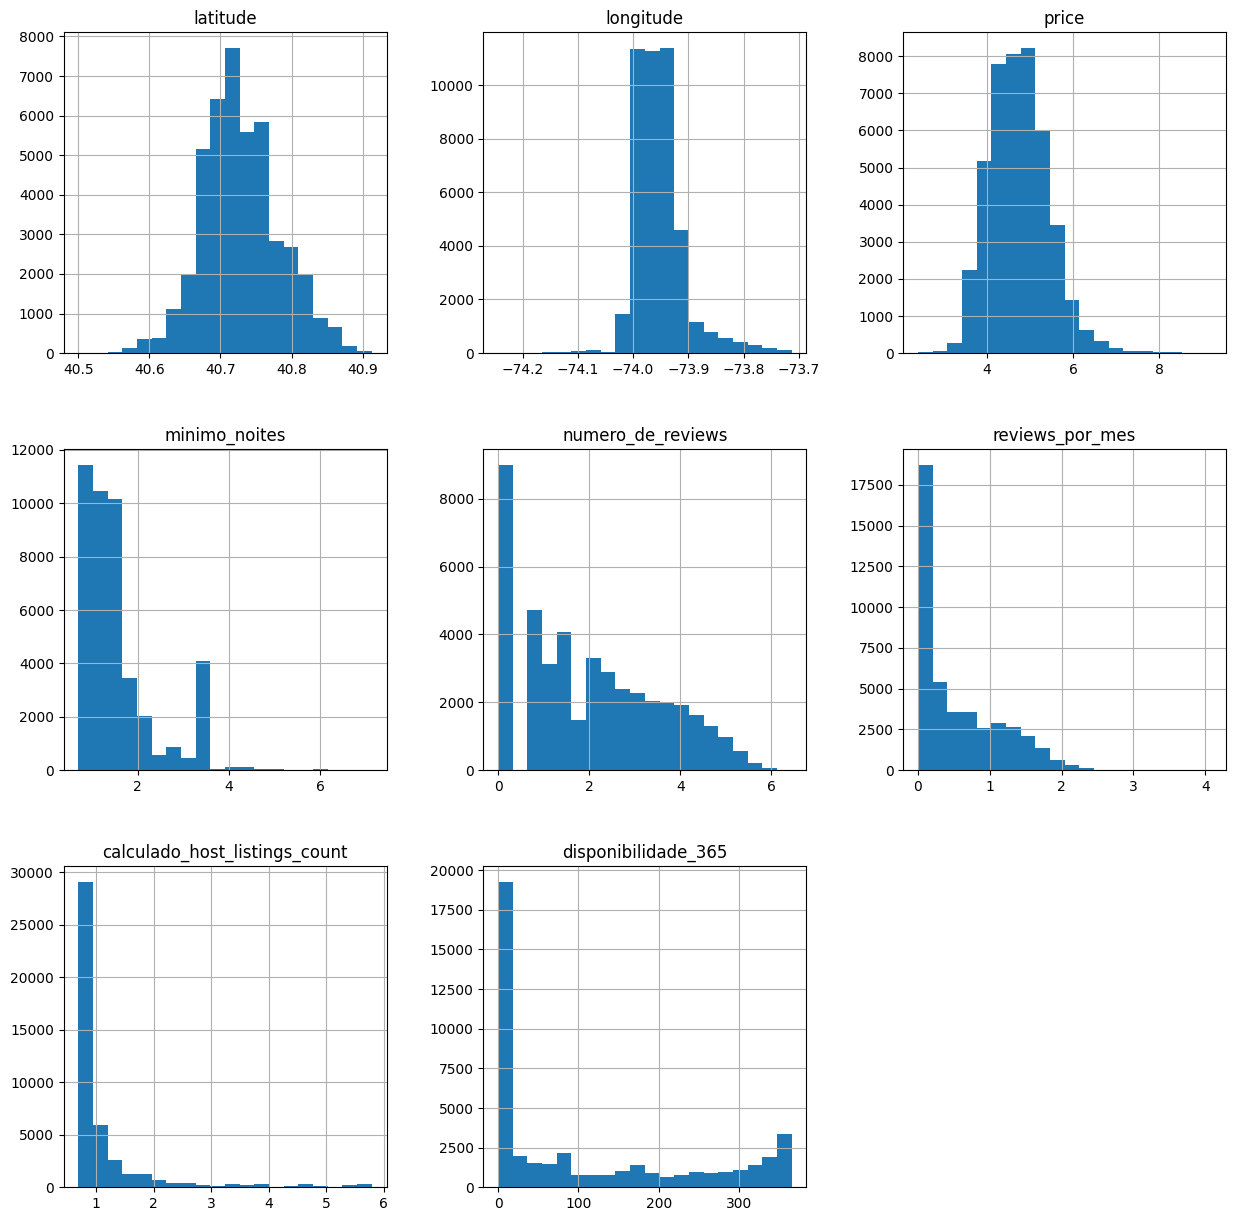

In [ ]:
# Aplicando a funcao
df_treino_log = aplicar_log(df_treino,['price', 'minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count'])

# Verificando distribuicoes
df_treino_log.drop(['id', 'host_id','ultima_review'], axis = 1).hist(figsize=(15,15), bins=20)

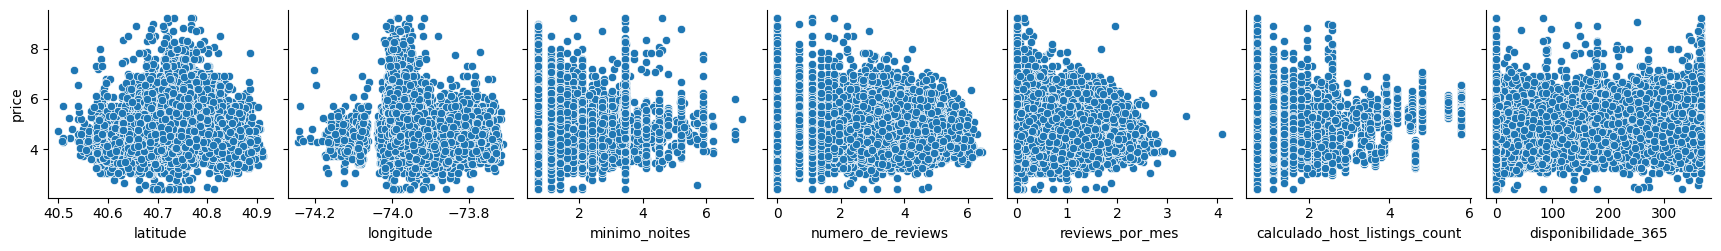

In [ ]:
# Plotando scatter plots das variaveis em relacao a variavel alvo price
sns.pairplot(data=df_treino_log, y_vars='price', x_vars=variaveis_continuas_lista, kind = 'scatter')

In [ ]:
df_treino_log.select_dtypes(include=['int64', 'float64']).drop(columns=['id','host_id']).corr().price.abs().sort_values(ascending=False)

,price
price,1.000000
longitude,0.327783
disponibilidade_365,0.095656
latitude,0.079470
numero_de_reviews,0.067796
minimo_noites,0.064343
reviews_por_mes,0.063177
calculado_host_listings_count,0.049514


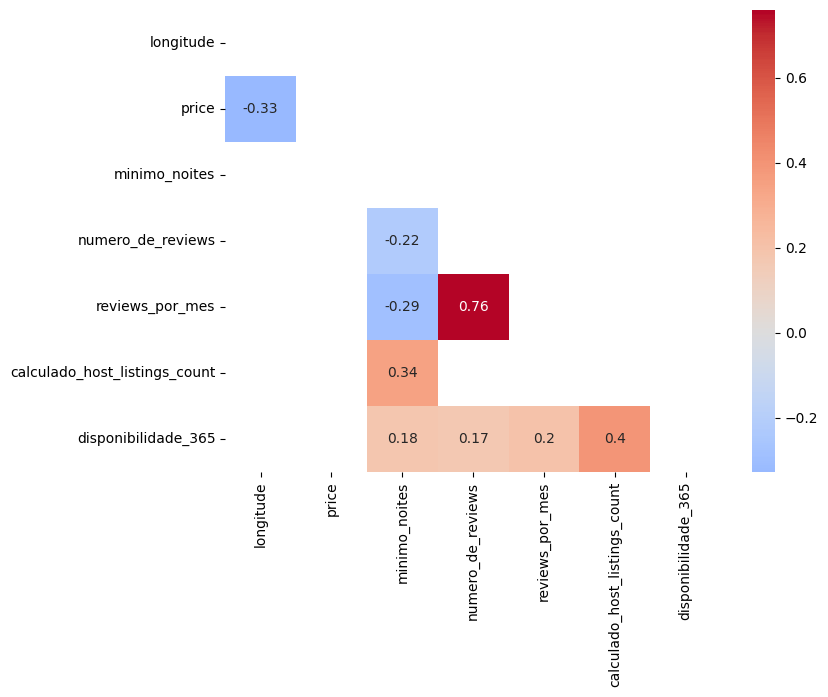

In [ ]:
# Gerando a matriz de correlacao entre as variaveis filtrando apenas as que tem correlacao mais que 0.15 em valor absoluto
filtrar_e_visualizar_correlacao(df=df_treino_log.select_dtypes(include=['int64', 'float64']), threshold=0.15, drop_column= ['id', 'host_id'])

Ao aplicar a transformação de log o resultado foi semelhante.

### Conclusão:
- Não há relação linear forte entre a variáveis alvo e as variáveis preditoras.
- Não há relação linear forte entre as variáveis.

### Pergunta: O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

### Estratégia:
Como as variáveis tem baixa correlação linear, não parece ser uma boa estratégia usar regressão linear para explicar a variabilidade do preço em função do número mînimo de noites e da disponibilidade.

Os dados também não seguem uma distribuição normal para aplicarmos testes estatísticos como o teste t.

então eu vou categorizar as variáveis usando os intervalos entre os seus quartis e aplicar o teste não paramétrico de Kruskal-Wallis.

In [ ]:
# Funcao para categorizar as variaveis pelos seus quartis
def categorizar_por_quartis(df, coluna, nome_novo, labels=None, n_amostras=3600):

    df_copia = df.copy()

    if labels is None:
        labels = ["baixo", "médio", "alto"]

    # Criar categorias com base nos quartis
    df_copia[nome_novo] = pd.qcut(df_copia[coluna], q=4, labels=labels, duplicates='drop')

    # Balancear as categorias para garantir mesmo número de amostras por grupo
    df_copia = df_copia.groupby(nome_novo, group_keys=False).apply(
        lambda x: x.sample(n=min(n_amostras, len(x)), random_state=42)
    ).reset_index(drop=True)

    return df_copia

In [ ]:
# Criando categorias para disponibilidade_365
df_cat = categorizar_por_quartis(df_treino, 'disponibilidade_365', 'disponibilidade_365_cat',n_amostras=5000)

In [ ]:
# Criando categorias para minimo_noites
df_cat_2 = categorizar_por_quartis(df_treino, 'minimo_noites', 'minimo_noites_cat', n_amostras=3600)

In [ ]:
# Funcao para realizar o teste de Kruskal-Wallis
def realizar_teste_kruskal(df, coluna_categoria, coluna_valor):

    categorias = df[coluna_categoria].unique()
    amostras = [df[df[coluna_categoria] == cat][coluna_valor] for cat in categorias]

    # Teste de Kruskal-Wallis
    stat, pvalue = kruskal(*amostras)

    print(f"\n=== Teste de Kruskal-Wallis para '{coluna_categoria}' ===")
    print(f'Estatística H: {stat:.2f}')
    print(f'Valor p: {pvalue:.5f}')

    # Interpretação do resultado
    if pvalue < 0.05:
        print("Rejeitamos H0: Há diferença significativa entre as categorias.\n")
    else:
        print("Falha em rejeitar H0: As categorias possuem distribuições similares.\n")

    # Exibir a mediana dos preços por categoria
    for cat in categorias:
        mediana = df[df[coluna_categoria] == cat][coluna_valor].median()
        print(f"Mediana do preço para '{cat}': {mediana:.2f}")

In [ ]:
# Aplicar o teste de Kruskal-Wallis para disponibilidade_365_cat
realizar_teste_kruskal(df_cat, 'disponibilidade_365_cat', 'price')


=== Teste de Kruskal-Wallis para 'disponibilidade_365_cat' ===
Estatística H: 93.95
Valor p: 0.00000
Rejeitamos H0: Há diferença significativa entre as categorias.

Mediana do preço para 'baixo': 100.00
Mediana do preço para 'médio': 105.00
Mediana do preço para 'alto': 122.00


In [ ]:
# Aplicar o teste de Kruskal-Wallis para minimo_noites_cat
realizar_teste_kruskal(df_cat_2, 'minimo_noites_cat', 'price')


=== Teste de Kruskal-Wallis para 'minimo_noites_cat' ===
Estatística H: 53.14
Valor p: 0.00000
Rejeitamos H0: Há diferença significativa entre as categorias.

Mediana do preço para 'baixo': 100.00
Mediana do preço para 'médio': 125.00
Mediana do preço para 'alto': 117.00


De acordo com o teste, temos confiança estatística suficiente para afirmar que os valores de minimo_noites_cat e disponibilidade_365_cat impactam nos preços.

1. Quando o minimo_de_noites é baixo, os preços são significantivamente mais baixos do que quando o minimo_de_noites é médio ou alto.

2. O preço é significantivamente maior conforme a maior a disponibilidade,o que corrobora com a hipótese anterior que os imóveis mais caros tem maior disponibilidade por serem de mais dificil acesso, ou seja, só são acessíveis para pessoas com maior poder aquisitivo.

### Vamos verificar as variáveis categóricas

In [ ]:
# Resumo estatîstico
df_original.describe(include = 'object')

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,48878,48873,48894,48894,48894,38842
unique,47904,11452,5,221,3,1764
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,18,417,21661,3920,25409,1413


In [ ]:
# Verificando categorias de room_type
df_original['room_type'].value_counts()

,count
room_type,
Entire home/apt,25409
Private room,22325
Shared room,1160


Os dados das classes em room_type são balanceados em relação a Entire home/apt e Private room. Mas tem uma quantidade bem menor de Shared room

<Axes: xlabel='room_type', ylabel='price'>

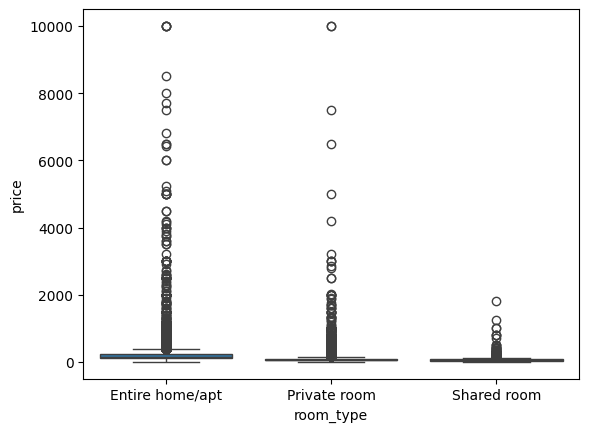

In [ ]:
# Verificando a distribuicao da variavel alvo para os diferentes room_type
sns.boxplot(data = df_original, x = 'room_type', y = 'price')

Como esperado shared room tem menores preços (por serem compartilhadas)

In [ ]:
# Verificando categorias de bairro_group
df_original['bairro_group'].value_counts()

,count
bairro_group,
Manhattan,21661
Brooklyn,20103
Queens,5666
Bronx,1091
Staten Island,373


<Axes: xlabel='bairro_group', ylabel='price'>

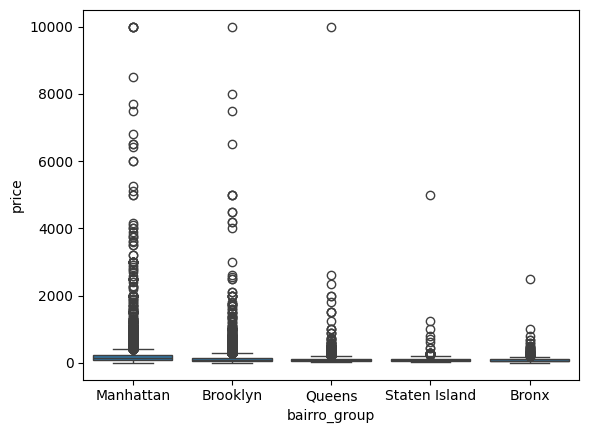

In [ ]:
# Verificando a distribuicao da variavel alvo para os diferentes bairro_group
sns.boxplot(data = df_original, x = 'bairro_group', y = 'price')

Manhattan e brooklyn tem valores mais elevados que os demais bairro_group

### Pergunta: Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


### Vamos verificar a relação entre disponibilidade e disponibilidade_365

<Axes: xlabel='bairro_group', ylabel='disponibilidade_365'>

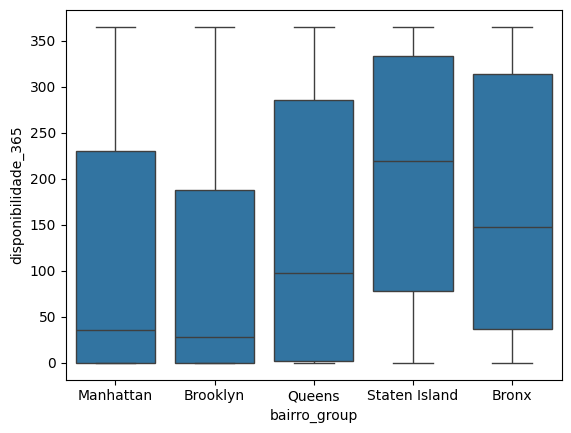

In [ ]:
sns.boxplot(data = df_original, x = 'bairro_group', y = 'disponibilidade_365')

Staten Island e Bronx parecem ser onde os apartamentos estão mais disponíveis no geral, apesar de ser onde tem menos apartamentos, o que pode significar menor procura nessas áreas.

Manhattan e Brooklyn é ao contrário, temos menos imóveis disponíveis, porém também é onde tem a maior oferta, o que pode significar maior procura.

Já o Queens fica no meio termo entre as duas situaçoes.

In [ ]:
# Verificando os precos em relação a room_type usando groupby
df_original.groupby(['bairro_group','room_type'])['price'].median()

bairro_group   room_type      
Bronx          Entire home/apt    100.0
               Private room        53.5
               Shared room         40.0
Brooklyn       Entire home/apt    145.0
               Private room        65.0
               Shared room         36.0
Manhattan      Entire home/apt    191.0
               Private room        90.0
               Shared room         69.0
Queens         Entire home/apt    120.0
               Private room        60.0
               Shared room         37.0
Staten Island  Entire home/apt    100.0
               Private room        50.0
               Shared room         30.0
Name: price, dtype: float64

In [ ]:
# Verificando os precos em relação a room_type usando groupby
df_original.groupby(['bairro_group'])['numero_de_reviews'].sum()

,numero_de_reviews
bairro_group,
Bronx,28371
Brooklyn,486565
Manhattan,454569
Queens,156950
Staten Island,11541


### Resposta da pergunta
Comprar um shared room no Brooklyn parece ser uma boa alternativa para investimento, já que é um local de alta procura e os valores de aluguel não são altos, o que deve compartilhar com o valor da compra também.

Outra opção mais óbvia de alta rentabilidade seria investir em Manhattan, já que tem alta demanada, porêm seria um investimento mais caro.

Queens também parece ser uma opção interessante para um perfil de investimento a longo prazo, já que tem um bom custo benefício (sendo intermediário em procura e preços) e um bom número de reviews, mostrando rotatividade e permitindo ter confiabilidade no investimento.

### Agora vamos verificar a variavel ultima review que e do tipo data

<Axes: xlabel='ultima_review', ylabel='price'>

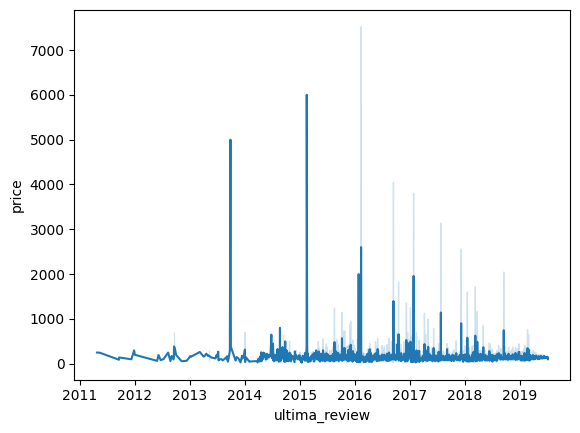

In [ ]:
# verificando a relacao com o preco
sns.lineplot(data = df_treino, x = 'ultima_review', y = 'price')

Aparentemente existem existem picos quando a ultima review foi feita no final ou inicio do ano, vamos dividir a varivel em ano, mes e dia da semana.

In [ ]:
# Cria uma copia do dataframe de treino
df_dias = df_treino.copy()

# Extrair ano, mês e dia da semana da coluna 'ultima_review'
df_dias['ano'] = df_treino['ultima_review'].dt.year
df_dias['mes'] = df_treino['ultima_review'].dt.month
df_dias['dia_semana'] = df_treino['ultima_review'].dt.weekday

# Preencher valores nulos em 'ano', 'mes' e 'dia_semana' com 0
df_dias[['ano', 'mes', 'dia_semana']] = df_dias[['ano', 'mes', 'dia_semana']].fillna(0)

# Verificar se há valores nulos após imputação
print(df_dias[['ano', 'mes', 'dia_semana']].isnull().sum().sort_values(ascending=False))

ano           0
mes           0
dia_semana    0
dtype: int64


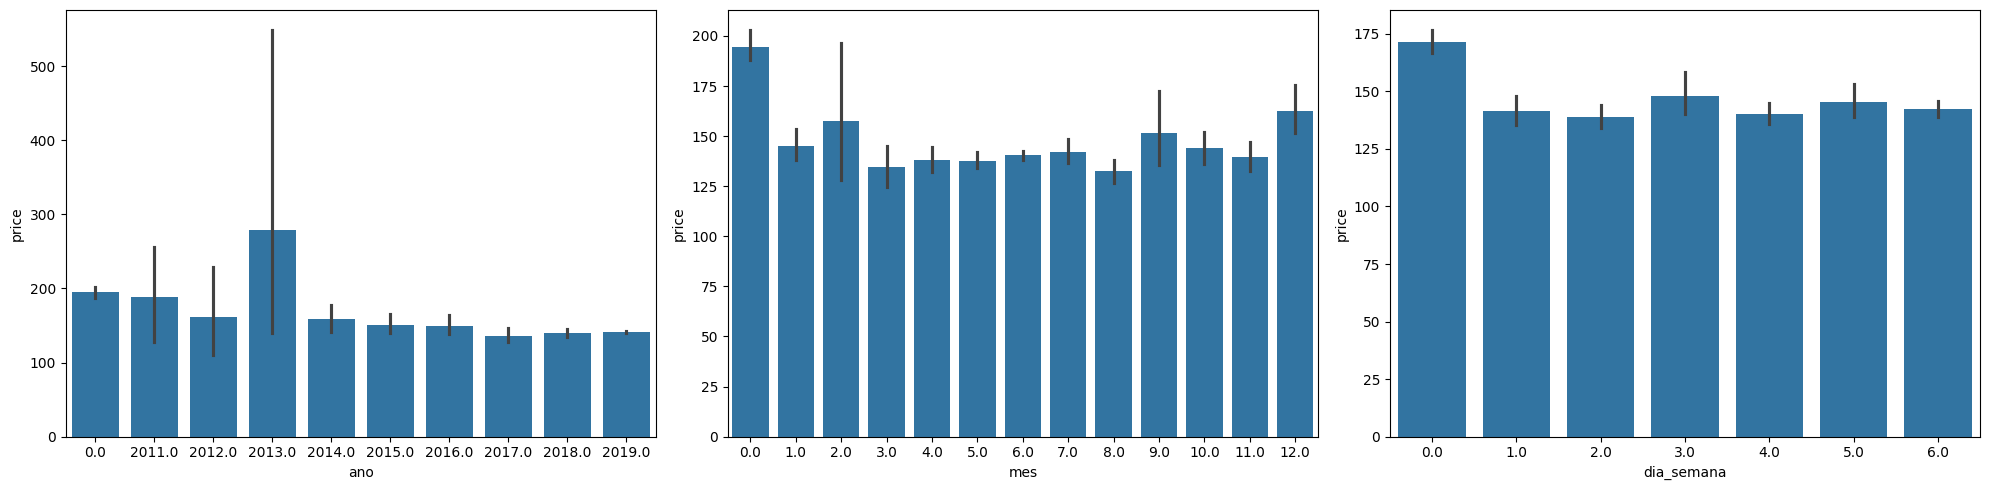

In [ ]:
# Gerando gráficos para ver o impacto de ano, mes e dia_semana da última review no preço
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plotando o gráfico para 'ano' no eixo 0
sns.barplot(data=df_dias, x='ano', y='price', ax=ax[0])

# Plotando o gráfico para 'mes' no eixo 1
sns.barplot(data=df_dias, x='mes', y='price', ax=ax[1])

# Plotando o gráfico para 'dia_semana' no eixo 2
sns.barplot(data=df_dias, x='dia_semana', y='price', ax=ax[2])

# Exibindo os gráficos
plt.tight_layout()
plt.show()

Aparentemente a data da última review não tem muita relação com o preço, os valores são bem uniformes.

### Pergunta: Existe algum padrão no texto do nome do local para lugares de mais alto valor?

estratégia: vou tokenizar o texto da coluna nome em palavras e verificar se existem palavras que aparecem com frequência nos apartamentos mais caros.

### Crianco uma função para processamento de texto

1. colocar tudo em caixa baixa

2. remover pontuacao

3. remover stopwors (palavras sem significado relevante)

4. tokenizar o texto em palavras

In [ ]:
# Implementando a funcao
def clean_text(text):

    if isinstance(text, str):

        text = text.lower()

        text = ''.join([char for char in text if char not in string.punctuation])

        words = word_tokenize(text)

        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

        return words
    else:
        return []  # Retorna uma lista vazia para valores não string

In [ ]:
df_treino['nome'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 43994 entries, 0 to 43993
Series name: nome
Non-Null Count  Dtype 
--------------  ----- 
43980 non-null  object
dtypes: object(1)
memory usage: 343.8+ KB


In [ ]:
# Supondo que você tenha um DataFrame df_input_nulls
df_words = df_treino.copy()

# Remove valores onde nome é nulo
df_words = df_words.dropna(subset=['nome'])

# Aplicando a função de limpeza na coluna 'nome'
df_words['texto_limpo'] = df_words['nome'].apply(clean_text)

# Unindo as palavras em uma lista e contar a frequência
all_words = [word for sublist in (df_words['texto_limpo'][df_words.price > df_words.price.quantile(0.99)]) for word in sublist]
freq_dist = FreqDist(all_words)

# Exibir as palavras mais frequentes
print(freq_dist.most_common(30))

[('luxury', 48), ('loft', 48), ('townhouse', 44), ('private', 41), ('bedroom', 38), ('apartment', 35), ('village', 33), ('nyc', 33), ('2', 32), ('park', 29), ('manhattan', 26), ('apt', 26), ('new', 25), ('east', 24), ('brooklyn', 23), ('room', 22), ('beautiful', 21), ('west', 21), ('penthouse', 19), ('views', 18), ('soho', 17), ('3', 17), ('central', 17), ('duplex', 17), ('bed', 17), ('w', 16), ('suite', 16), ('heart', 15), ('studio', 14), ('1', 14)]


vemos aqui algumas palavras que são usadas para fazer referência a apartmentos de maior padrão:

- luxury → luxo
- loft → loft (tipo de apartamento com espaço aberto)
- townhouse → casa geminada / sobrado
- penthouse → cobertura
- views → vistas / visão panorâmica
- central → central
- duplex → duplex (apartamento/casa de dois andares)
- suite → suíte (quarto com banheiro privativo)
- heart → coração (como em "no coração da cidade")

Mas a quantidade é baixa para ser utilizado de forma útil para o modelo.

### Engenharia de recursos

vamos criar uma nova variável que calcula a distância do imóvel para o central park, pode ser util para o modelo preditivo.

In [ ]:
# definindo a funcao
def calcular_distancia_central_park(df, lat_col='latitude', lon_col='longitude', coordenadas_ref=(40.782857, -73.965232)):
    df['distancia_central_park'] = df.apply(
        lambda linha: geodesic((linha[lat_col], linha[lon_col]), coordenadas_ref).km, axis=1
    )
    return df

In [ ]:
# Aplicando a funcao aos dados de treino e teste
df_treino = calcular_distancia_central_park(df_treino)
df_teste = calcular_distancia_central_park(df_teste)

# verificando se a coluna foi adicionada
df_treino.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park'],
      dtype='object')

<Axes: xlabel='distancia_central_park', ylabel='price'>

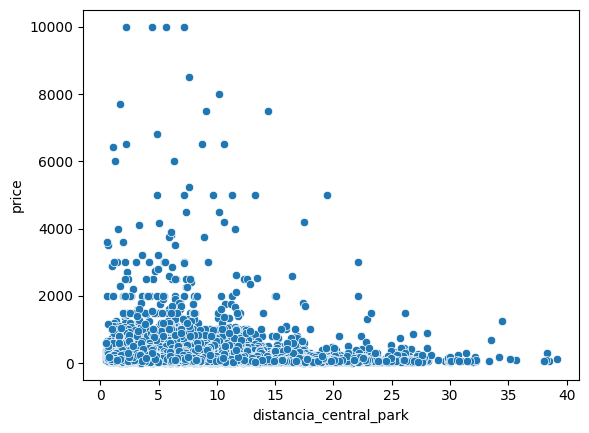

In [ ]:
# Verificando grafico de dispersao entre preco e distancia ao central park
sns.scatterplot(data = df_treino, x = 'distancia_central_park', y = 'price')

Como esperado quanto mais distante do central park menores os preços, possivelmente essa variável será útil.

#### Pré - Processamento dos dados e Modelagem

nessa fase algumas decisões terão de ser tomadas então vamos responder o seguinte enunciado:

**Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?**

Estamos lidando com um problema de regressão pois a variável alvo price é um valor contínuo, o objetivo aqui é encontrar a relação entre as variáveis preditoras e a variável alvo a fim de fazer um boa generalização para novos dados.

Durante a minha análise exploratória percebi que a variável alvo tem baixa correlação com as variáveis preditoras, e mesmo aplicando transformação logaritmica essa correlação continuou baixa, o que dificulta a aplicação de modelos lineares como a regressão linear e suas variações como ridge ou lasso. Nesse contextovou optar por utilizar o modelo de random forest pois ele é capaz de capturar relações não lineares entre as variáveis. Além disso ele é robusto a outliers, dados em diferentes escalas e distribuições assimétricas, que é o caso aqui, facilitando o pré-processamento. Por outro lado random forest consome bastante memoria e é sensível a overfitting, além de ser sensível também a uma dimensionalidade muito alta nos dados.

Não irei utilizar as variáveis:

1. nome: Pode ser que ainda tenha algum padrão útil fazendo um análise mais profunda, mas ao verificar as palavras-chave não identifiquei algo que possa ajudar o modelo.

2. host_id: variável de id.

3. host_name: apeans o nome do dono do imovel, não parece relevante.

4. bairro: poderia ser olhada mais afundo, mas adicionaria alta dimensionalidade se aplicar one-hot encoding, necessitando de um pré-processamento mais robusto.

3. ultima_review: nao pareceu tão relevante quanto outras variáveis durante a análise exploratória, não encontrei padrões de como ele pode impactar no preço.

4. reviews_por_mes: redundante com numero de reviews.

Algoritmos de arvore não exigem um pré-processamento muito robusto geralmente, então para transformar as variáveis apenas imputei 0 nos valores ausentes de disponibilidade_365, aplicarei one-hot-encoding nas variaveis categóricas(ja que não tem ordem entre as categorias) e logaritmo nas variáveis contínuas, apesar de algoritmos baseados em arvore serem robustos a escala dos dados e outliers a suavizacao dos dados pode ser benéfica para os pontos de corte do algoritmo.

Como métricas utilizarei o coeficiente de determinação (Rˆ2)que varia de 0 a 1 medindo em que proporção as variáveis preditoras conseguem explicar a variabilidade da variável alvo.
MAE - mean absolute error,mede o erro médio do modelo entre as previsões e os valores reais, mas não diferecia erros pequenos de erros grandes.
MSE -  mean squared error, eleva o erro ao quadrado antes de calcular a média, penalizando erros maiores.




In [ ]:
df_treino.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park'],
      dtype='object')

In [ ]:
# Lista de colunas numericas que serao utilizadas
colunas_numericas = ['latitude', 'longitude','minimo_noites',
       'numero_de_reviews','calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park','price']

# Lista de colunas categoricas que serao utilizadas
colunas_categoricas = ['room_type', 'bairro_group']

In [ ]:
# Filtrar dataframes de treino e teste apenas com as colunas que serao utilizadas
df_treino = df_treino[colunas_numericas + colunas_categoricas]
df_teste = df_teste[colunas_numericas + colunas_categoricas]

In [ ]:
# Verificando
df_treino.columns

Index(['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park', 'price', 'room_type', 'bairro_group'],
      dtype='object')

In [ ]:
# Verificando
df_teste.columns

Index(['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park', 'price', 'room_type', 'bairro_group'],
      dtype='object')

In [ ]:
# Verificando valores nulos
df_treino.isnull().values.any()

False

In [ ]:
# Verificando valores nulos
df_teste.isnull().values.any()

False

In [ ]:
# Criando o OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Aplicar One-Hot Encoding nos dados de treino e teste
df_treino_cat = pd.DataFrame(one_hot_encoder.fit_transform(df_treino[colunas_categoricas]),
                             columns=one_hot_encoder.get_feature_names_out(),
                             index=df_treino.index)

df_teste_cat = pd.DataFrame(one_hot_encoder.transform(df_teste[colunas_categoricas]),
                            columns=one_hot_encoder.get_feature_names_out(),
                            index=df_teste.index)

# Concatenar os dados transformados com as colunas numéricas originais
df_treino_final = pd.concat([df_treino.drop(columns=colunas_categoricas), df_treino_cat], axis=1)
df_teste_final = pd.concat([df_teste.drop(columns=colunas_categoricas), df_teste_cat], axis=1)

# Exibir as primeiras linhas do dataframe transformado
df_treino_final.columns

Index(['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park', 'price', 'room_type_Private room',
       'room_type_Shared room', 'bairro_group_Brooklyn',
       'bairro_group_Manhattan', 'bairro_group_Queens',
       'bairro_group_Staten Island'],
      dtype='object')

In [ ]:
# Variaveis para aplicar o log
lista_log = ['price', 'minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count']

# Aplicar funcao de transformacao de log nos dados de treino e teste nas variaveis ma distribuidas
df_treino_final = aplicar_log(df_treino_final, lista_log)
df_teste_final = aplicar_log(df_teste_final, lista_log)

# Testando
df_treino_final.describe()

,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,distancia_central_park,price,room_type_Private room,room_type_Shared room,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island
count,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000,43994.000000
mean,40.728986,-73.952305,1.500016,1.991384,1.087433,112.578897,8.150929,4.737675,0.456380,0.023776,0.411170,0.443356,0.115902,0.007524
std,0.054470,0.045948,0.868656,1.562544,0.859654,131.544966,4.710427,0.691784,0.498099,0.152352,0.492052,0.496787,0.320111,0.086414
min,40.499790,-74.244420,0.693147,0.000000,0.693147,0.000000,0.462228,2.397895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690190,-73.983110,0.693147,0.693147,0.693147,0.000000,4.427889,4.248495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.723170,-73.955760,1.386294,1.791759,0.693147,45.000000,7.598123,4.672829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.763130,-73.936422,1.791759,3.218876,1.098612,225.000000,11.061940,5.170484,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,40.913060,-73.712990,7.131699,6.445720,5.793014,365.000000,39.135644,9.210440,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Vendo o dataframe final
df_treino_final.head()

,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,distancia_central_park,price,room_type_Private room,room_type_Shared room,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island
0,40.74434,-73.97758,1.098612,1.098612,1.386294,297,4.402523,3.988984,0.0,1.0,0.0,1.0,0.0,0.0
1,40.67772,-73.92330,1.098612,2.944439,0.693147,310,12.200866,4.025352,1.0,0.0,1.0,0.0,0.0,0.0
2,40.68326,-73.99327,1.386294,3.332205,0.693147,166,11.310879,4.753590,0.0,0.0,1.0,0.0,0.0,0.0
3,40.67708,-73.95489,2.079442,0.693147,0.693147,35,11.778843,5.170484,0.0,0.0,1.0,0.0,0.0,0.0
4,40.65046,-73.93633,1.098612,3.178054,0.693147,149,14.903911,4.454347,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#  Definindo uma função para reverter a transformação logarítmica
def inverso_log(x):
    return np.exp(x)

In [ ]:
# Instanciando o modelo
rf_modelo = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    criterion="squared_error",
    n_jobs=-1,
    random_state=42
)

# Separando variáveis independentes (X) e dependente (y)
X = df_treino_final.drop(columns=['price'])
y = df_treino_final['price']

# Avaliação do modelo com validação cruzada (3 folds)
scores = cross_val_score(rf_modelo, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Convertendo os erros para valores positivos
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

# Exibindo a média e desvio padrão do RMSE
print(f" Média do RMSE: {rmse_scores.mean():.2f}")
print(f" Desvio Padrão do RMSE: {rmse_scores.std():.2f}")

# Treinando o modelo para obter importâncias das features
rf_modelo.fit(X, y)

# Obtendo importâncias das features
importances = rf_modelo.feature_importances_

# Pegando os nomes das colunas corretamente
feature_names = X.columns

# Criando DataFrame de importâncias
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importances = df_importances.sort_values(by='importance', ascending=False)

 Média do RMSE: 0.44
 Desvio Padrão do RMSE: 0.00


In [ ]:
df_importances.head(14)

,feature,importance
7,room_type_Private room,0.320506
1,longitude,0.168488
0,latitude,0.110247
6,distancia_central_park,0.094938
5,disponibilidade_365,0.080396
8,room_type_Shared room,0.065015
3,numero_de_reviews,0.058132
2,minimo_noites,0.052053
4,calculado_host_listings_count,0.032407
10,bairro_group_Manhattan,0.015697


In [ ]:
# Salvando o modelo em formato pkl
with open('modelo_rf.pkl', 'wb') as file:
    pickle.dump(rf_modelo, file)

In [ ]:
# Realizando a predição nos dados de teste e avaliando
y_pred = rf_modelo.predict(df_teste_final.drop(columns=['price']))

# Calculando as métricas
mse = mean_squared_error(df_teste_final['price'], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(df_teste_final['price'], y_pred)
mae = mean_absolute_error(df_teste_final['price'], y_pred)

# Exibindo as métricas
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.31
MSE: 0.19
RMSE: 0.44
R²: 0.60


o valor de Rˆ2 mostra que o modelo explica cerca de 60% da variação da variável alvo.

## Prevendo em dados de exemplo

In [ ]:
# Definindo o novo exemplo
novo_exemplo = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

colunas_numericas_exemplo = ['latitude', 'longitude','minimo_noites',
       'numero_de_reviews','calculado_host_listings_count', 'disponibilidade_365',
       'distancia_central_park']



# Criando DataFrame para o novo exemplo
df_novo_exemplo = pd.DataFrame([novo_exemplo])

# Calcular distancia central park
df_novo_exemplo = calcular_distancia_central_park(df_novo_exemplo)

df_novo_exemplo = df_novo_exemplo[colunas_numericas_exemplo + colunas_categoricas]

# Aplicar One-Hot Encoding nos dados
df_novo_exemplo_cat = pd.DataFrame(one_hot_encoder.fit_transform(df_novo_exemplo[colunas_categoricas]),
                             columns=one_hot_encoder.get_feature_names_out(),
                             index=df_novo_exemplo.index)


# Concatenar os dados transformados com as colunas numéricas originais
df_novo_exemplo_final = pd.concat([df_novo_exemplo.drop(columns=colunas_categoricas), df_novo_exemplo_cat], axis=1)

df_novo_exemplo_final = aplicar_log(df_novo_exemplo_final, lista_log)

df_novo_exemplo_final = df_novo_exemplo_final.reindex(columns=X.columns, fill_value=0)

# Realizando a previsão com o modelo treinado
y_novo_exemplo_log = rf_modelo.predict(df_novo_exemplo_final.drop(columns=['price'], errors='ignore'))

# Revertendo a transformação logarítmica para o novo exemplo
y_novo_exemplo = inverso_log(y_novo_exemplo_log)

print(f"Predição do preço para o novo exemplo: {y_novo_exemplo[0]:.2f}")

Predição do preço para o novo exemplo: 248.25
